In [ ]:
"""
LOAD NECESSARY FILES:
  Code
  Feature vectors for images
  Feature vectors for descriptions
  Images itself for display
  Sis and dii json files
"""

In [ ]:
%cd code

/content/code


In [ ]:
!pip3 install -r requirements.txt
!python setupNltk.py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle
import os
from torch.autograd import Variable
from data_loader import VistDataset
from build_vocab import Vocabulary
from model import EncoderStory, DecoderStory
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from disp_multiple_images import show_images
%matplotlib inline

In [ ]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [ ]:
image_dir = './dataset/test'
image_feature_dir = './dataset/testfeatures'
desc_dir = './dataset/testdesc'
sis_path = './data/sis/test.story-in-sequence.json'
dii_path = './data/dii/test.description-in-isolation.json'
encoder_path = './models/encoder-41.pkl'
decoder_path = './models/decoder-41.pkl'
vocab_path = './models/vocab.pkl'

img_feature_size = 768
embed_size = 256
hidden_size = 1024
num_layers = 2

In [ ]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
    
encoder = EncoderStory(img_feature_size, hidden_size, num_layers)
decoder = DecoderStory(embed_size, hidden_size, vocab)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

encoder.eval()
decoder.eval()

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


In [ ]:
images_dict = {}
sentences_dict = {}
image_files_dict = {"1": ["4267501373", "2217163903", "2229330283", "2234218140", "2212858297"],
               "2": ["2582414424", "2582415688", "2582423982", "2582423092", "2582414024"],
               "3": ["11301909", "11252935", "11251358", "11250886", "11249989"],
               "4": ["339659501", "339676362", "339685781", "339685786", "346521947"],
               "5": ['4597490260', '4613776404', '4621590112', '4624267732', '4604763963'],
               "6": ['32448587', '32448829', '32630023', '32630302', '32821349'],
               }

for id in image_files_dict.keys():
    image_files = []
    image_files.extend(image_files_dict[id])

    images = []
    image_tensor = []
    desc_tensor = []
    for i in range(5):
        image_data = torch.load(image_feature_dir + "/" + image_files[i][:2] + "/" + image_files[i] + ".pt")
        desc = torch.load(desc_dir + "/" + image_files[i][:2] + "/" + image_files[i] + ".pt") 
        image_tensor.append(image_data)
        desc_tensor.append(desc)
        image = Image.open(image_dir + '/' + image_files[i] + ".jpg").convert('RGB')
        images.append(image)

    images_dict[id] = images
    image_tensor = to_var(torch.stack(image_tensor).squeeze(1).unsqueeze(0))
    desc_tensor = to_var(torch.stack(desc_tensor).unsqueeze(0))

    feature, (h_n, c_n) = encoder(image_tensor, desc_tensor)
    inference_results = decoder.inference(feature.squeeze(0))

    sentences = []
    for i, result in enumerate(inference_results):
        words = []
        for word_id in result:
            word = vocab.idx2word[word_id.cpu().item()]
            words.append(word)
            if word == '<end>':
                break
                
        words.remove('<start>')
        try:
            words.remove('<end>')
        except Exception:
            pass
            
        sentences.append(' '.join(words))

    print(sentences)
    sentences_dict[id] = sentences


['the house was decorated for christmas .', 'the flowers were covered in snow .', 'the trees were covered with snow .', 'the path was frozen .', 'it was a nice day outside .']
['[ male ] was excited to go on a trip .', 'he was so excited to see the old ruins .', 'he walked around and saw a lot of trees .', 'then he went home .', 'his dog was very tired .']
['we went to the house for a walk .', 'there were a lot of old houses .', 'they were very small .', 'it was a nice place .', 'i had a great time .']
['the car was covered in snow .', 'the cars were covered with snow .', 'a man was seen on a blanket .', 'a cat was outside of the house .', 'a man was wearing a hat .']
['the house was covered in snow .', 'a dog was parked on the street .', 'a cat was nearby at the store .', 'a car was parked outside of a building .', 'a man played music .']
['the house was decorated with flowers .', 'the cat was very happy to be there .', 'he was excited for his new day .', 'she was glad that he was goi

In [ ]:
import json

sis_file = open("data/sis/test.story-in-sequence.json")
sis_data = json.load(sis_file)
sis_file.close()

dii_file = open("data/dii/test.description-in-isolation.json")
dii_data = json.load(dii_file)
dii_file.close()

original_story_dict = {}
original_desc_dict = {}

for id in image_files_dict.keys():
    image_files = []
    image_files.extend(image_files_dict[id])

    original_story = ["empty"] * 5
    for annotation in sis_data["annotations"]:
      if annotation[0]["photo_flickr_id"] in image_files:
        original_story[image_files.index(annotation[0]["photo_flickr_id"])] = annotation[0]["original_text"]

    original_desc = ["empty"] * 5
    for annotation in dii_data["annotations"]:
      if annotation[0]["photo_flickr_id"] in image_files:
        original_desc[image_files.index(annotation[0]["photo_flickr_id"])] = annotation[0]["original_text"]

    original_story_dict[id] = original_story
    original_desc_dict[id] = original_desc

    print("Descriptions")
    print("\n".join(original_desc))

    print("Target Story")
    print("\n".join(original_story))


Descriptions
A building that gives information to new tourists.
An eagle sitting on some branches on top of a green tree.
A deer sits on the only patch of ground not covered by snow
A man stares at the mountains and a deep gully caused by erosion.
The helicopter makes a landing in the snow with its rainbow tail
Target Story
Every summer we visit thr lodge. 
We go bird watching. 
We also practice animal tracking. 
The mountain scenery was so beautiful,
We almost always ebbs the our stay with a helicopter tour!
Descriptions
A boy is wearing a helmet and has a bicycle
Man on a bike coming down a paved road outside.
I person is riding a bike down the road in the forest
Boy on a bicycle wearing a helmet on a dock.
A boy that has fallen asleep in the front passenger seat in a car.
Target Story
Today we went for a long bike ride through the park.
The boy led the way and I followed behind. 
He was full of energy and couldn't stop exploring the park.
He made it to the dock and decided that was 

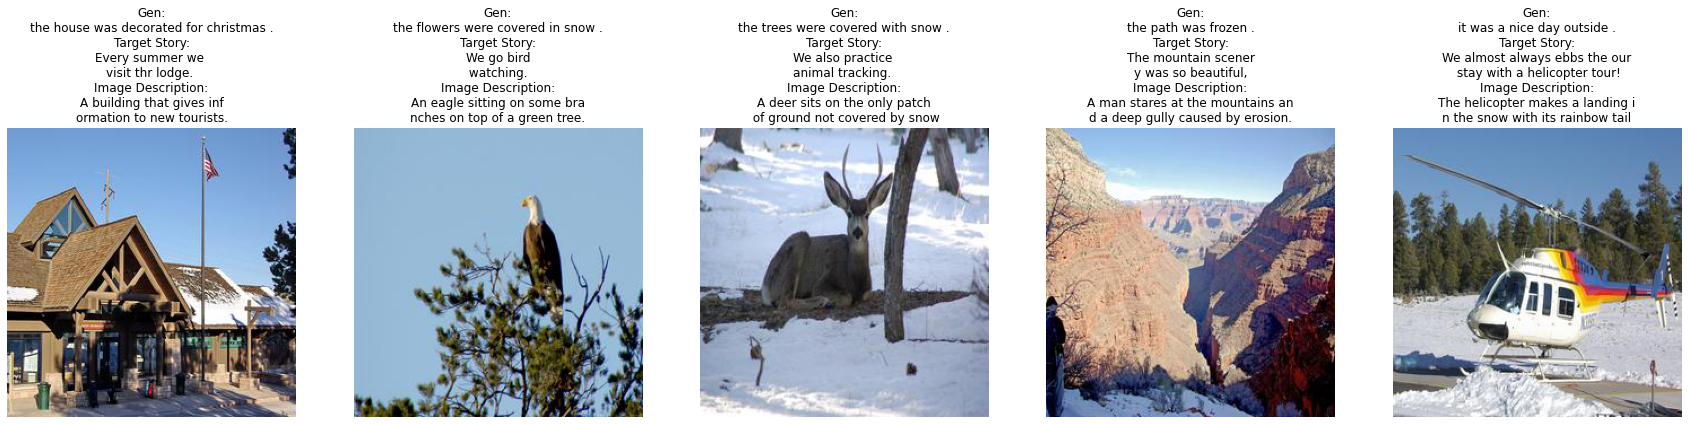

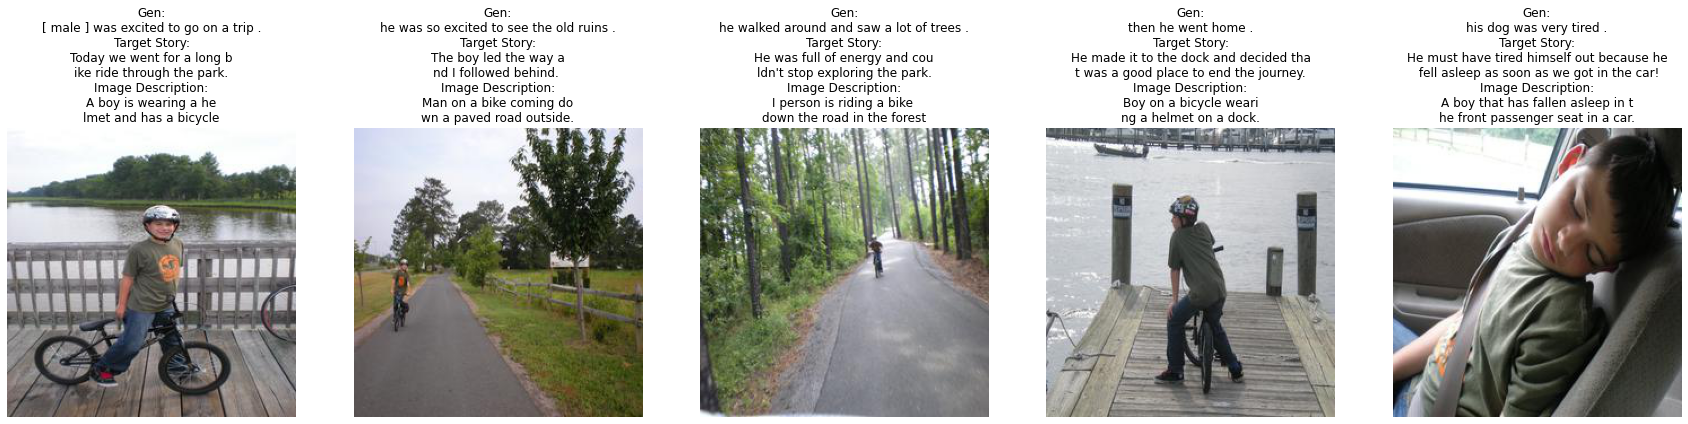

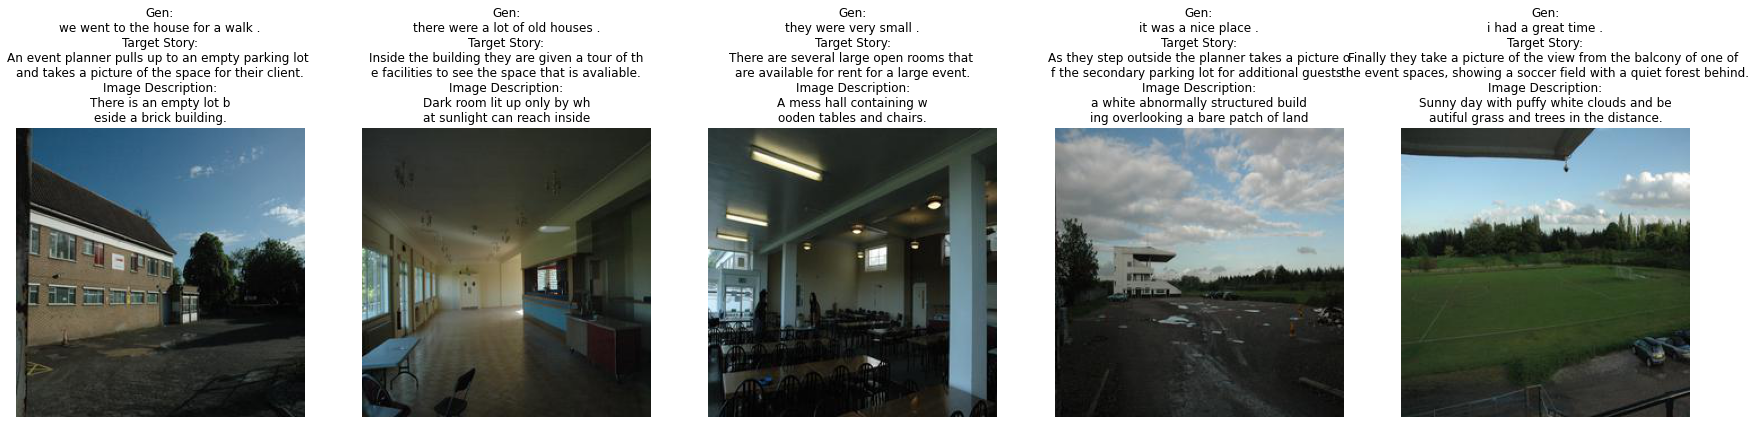

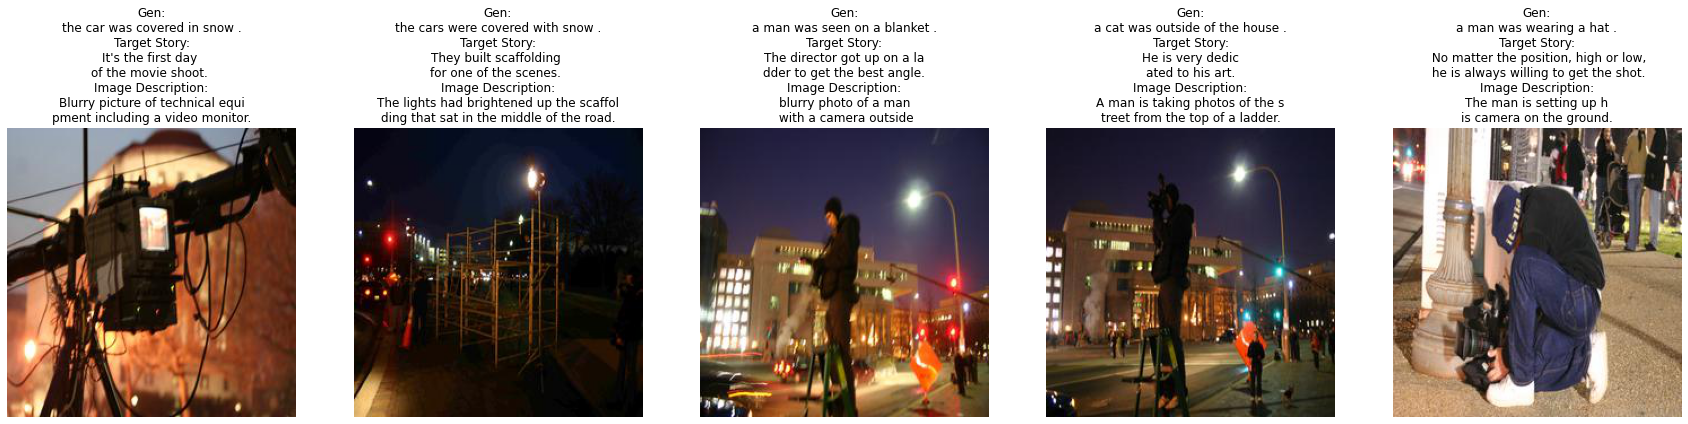

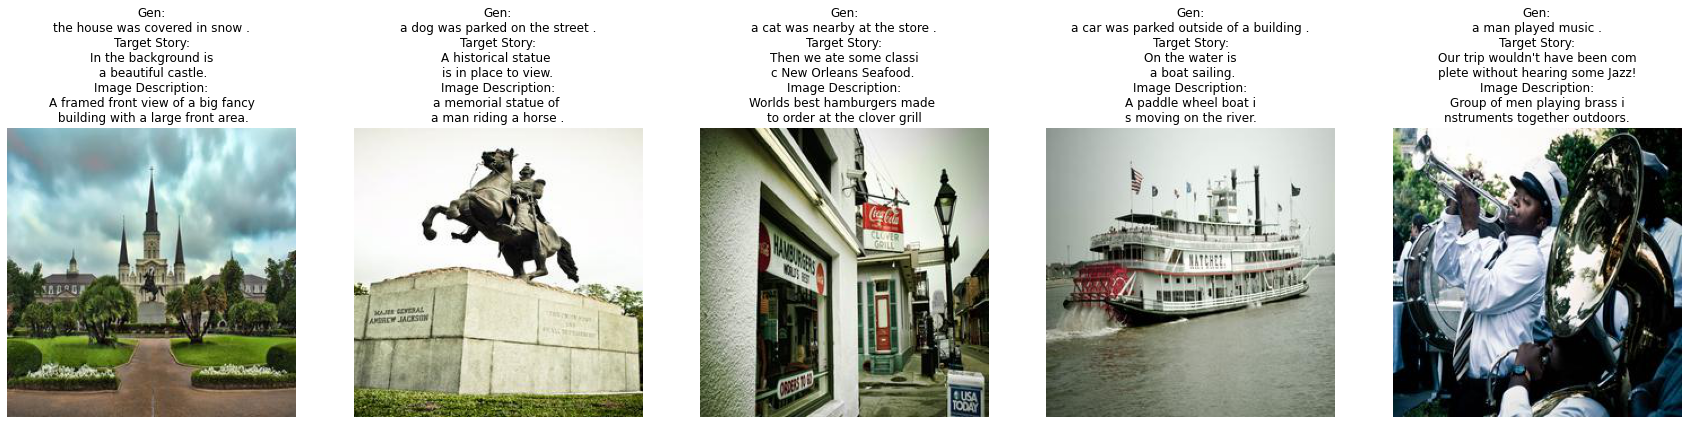

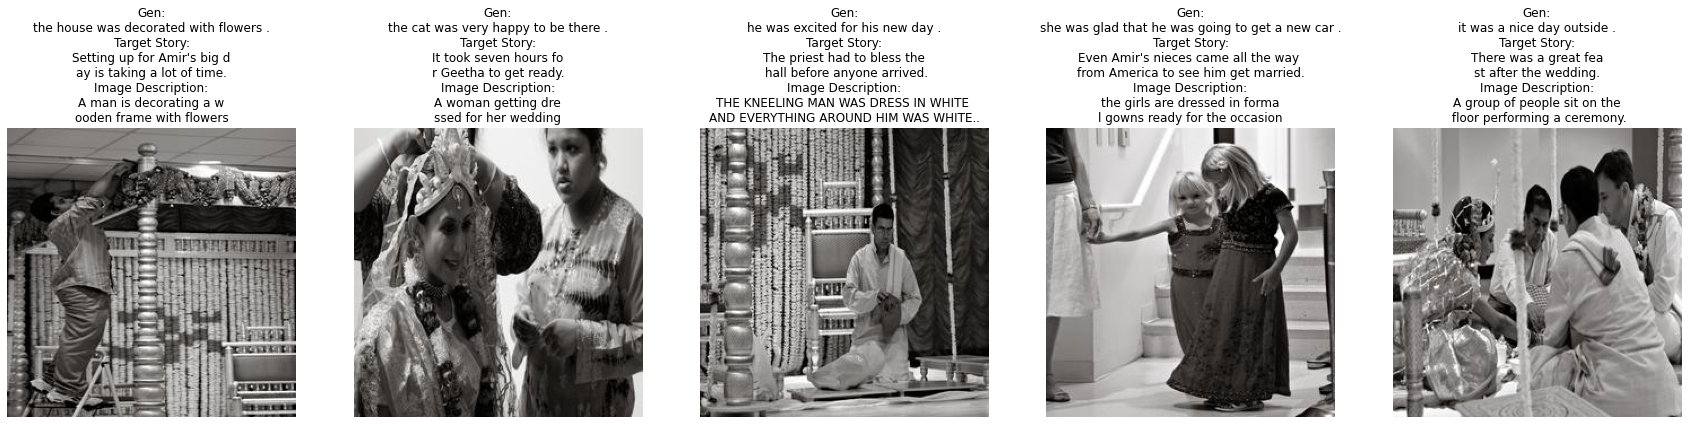

In [ ]:
for id in image_files_dict.keys():
  image_shows = images_dict[id]
  sentences = sentences_dict[id]
  original_story = original_story_dict[id]
  original_desc = original_desc_dict[id]
  imgs_show = []
  text_show = []
  for data in zip(image_shows, sentences, original_story, original_desc):
      imgs_show.append(np.asarray(data[0]))
      text_show.append("Gen:\n" + data[1]+ "\nTarget Story:\n" + data[2][:len(data[2])//2] + "\n" + data[2][len(data[2])//2:] + "\nImage Description:\n" + data[3][:len(data[3])//2] + "\n" + data[3][len(data[3])//2:])
    
  show_images(imgs_show, titles=text_show)

In [ ]:
REFERENCES

1- Huang, T.H., Ferraro, F., Mostafazadeh, N., Misra, I., Devlin, J., Agrawal, A., Girshick, R., He, X., Kohli, P., Batra, D., & others (2016).
Visual Storytelling. In 15th Annual Conference of the North American Chapter of the Association for Computational Linguistics (NAACL 2016).

2-Kim, T., Heo, M.O., Son, S., Park, K.W., & Zhang, B.T.. (2018). GLAC Net: GLocal Attention Cascading Networks for Multi-image Cued Story Generation. 
https://github.com/tkim-snu/GLACNet